In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
sc.logging.print_header()

warnings.filterwarnings('ignore')
os.chdir('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


In [20]:
rna = sc.read_h5ad('h5ad/adata_soupx_trans_cite_rna.h5ad')
adata = sc.read_h5ad('h5ad/adata_soupx_trans_cite_raw.h5ad')
adata3 = sc.read_h5ad('h5ad/adata_soupx_trans_cite_bgshift_raw.h5ad')

In [3]:
# clean up each major celltype
rnax = rna[rna.obs['fine_clustering'].isin(['CD4_Tnaive', 'CD4_Tcm', 'CD4_Tem', 'CD4_Th2', 'CD4_Treg', 'CD8_Tnaive', 'CD8_Tem', 'CD8_Temra'])].raw.to_adata().copy()
# Identify highly-variable genes
sc.pp.highly_variable_genes(rnax, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
## remove TRBV/TRAV and IGHV/IGLV/IGKV from the highly variable genes
import re
for i in rnax.var.index:
    if re.search('^TR[AB][VDJC]', i):
        rnax.var.at[i, 'highly_variable'] = False
# sc.pl.highly_variable_genes(rnax)
# stash the normalized data in raw
rnax.raw = rnax
# filter to only highly variable
rnax = rnax[:, rnax.var['highly_variable']]

In [4]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(rnax, ['total_counts', 'pct_counts_mt'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(rnax, max_value = 10)
sc.tl.pca(rnax, svd_solver = 'arpack')

In [5]:
# run harmony. compute the neighborhood graph.
sc.external.pp.harmony_integrate(rnax, key='study_id')
sc.pp.neighbors(rnax, use_rep = 'X_pca_harmony')
# sc.pp.neighbors(rnax)

2021-04-09 11:07:41,640 - harmonypy - INFO - Iteration 1 of 10
2021-04-09 11:08:10,844 - harmonypy - INFO - Iteration 2 of 10
2021-04-09 11:08:42,030 - harmonypy - INFO - Iteration 3 of 10
2021-04-09 11:09:01,885 - harmonypy - INFO - Iteration 4 of 10
2021-04-09 11:09:19,212 - harmonypy - INFO - Converged after 4 iterations


In [6]:
# run UMAP
sc.tl.umap(rnax, min_dist = 0.3)

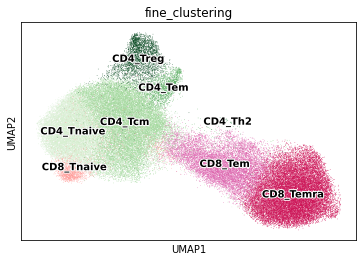

In [7]:
sc.pl.umap(rnax, color=['fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

In [8]:
adatax = adata3[adata3.obs_names.isin(rnax.obs_names)].copy()
adatax = adatax[:, adatax.var.feature_types == 'Antibody Capture']
adatax.obs = rnax.obs.copy()
adatax.obsm = rnax.obsm.copy()
adatax.obsp = rnax.obsp.copy()

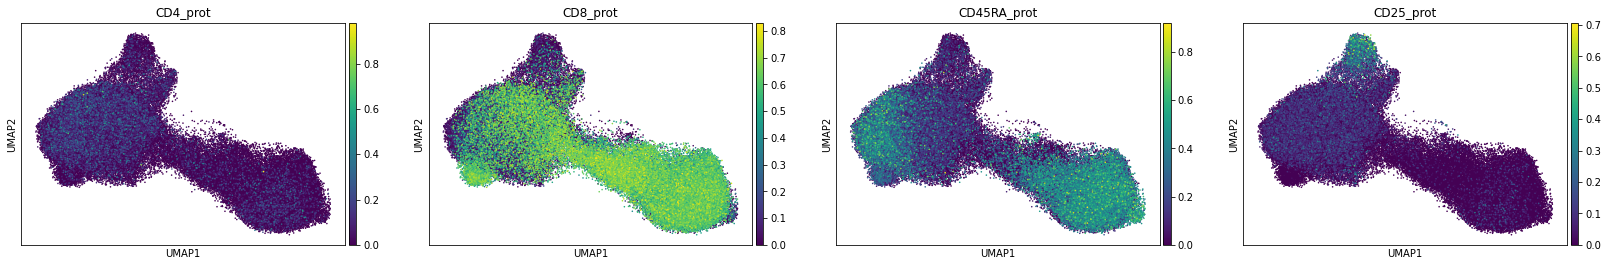

In [28]:
sc.pl.umap(adatax, color = ['CD4_prot', 'CD8_prot', 'CD45RA_prot', 'CD25_prot'], size = 10, vmin=)

In [31]:
import tools

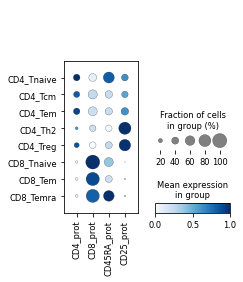

In [32]:
sc.pl.dotplot(adatax, ['CD4_prot', 'CD8_prot', 'CD45RA_prot', 'CD25_prot'], groupby = 'fine_clustering', standard_scale = 'var', color_map = 'Blues', save = 'cite_markers')

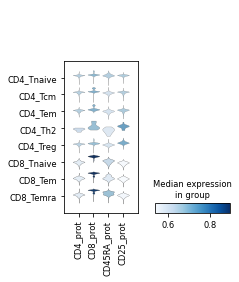

In [27]:
sc.pl.stacked_violin(adatax, ['CD4_prot', 'CD8_prot', 'CD45RA_prot', 'CD25_prot'], groupby = 'fine_clustering', standard_scale = 'var', color_map = 'viridis')